# Assignment 9: Final Project
## Computational Methods in Psychology (and Neuroscience)
### Psychology 4500/7559 --- Fall 2020


# Objectives

Upon completion of this assignment, students will have:

1. Described the list generation process in detail
2. Described the experiment details
3. Visualized processed data
4. Performed a statistical analysis to test the hypothesis

# Assignment

Write text (in MarkDown cells) and code (in Code cells) in a Jupyter notebook (after making a copy and renaming it to have your userid in the title --- e.g., A09_Final_Project_mst3k).


## Details

The goal of the final project is to synthesize material covered in the class and produce part of what would go into an actual scientific publication based on *one* of the experiments we ran in the class. Specifically, you will be writing part of the Methods and Results sections.

The basic template is below the code for loading and processing the data. There we outline what each section should include. As always, make sure to label all figures and be sure to refer to the code in the lesson notebooks as a guide for your analyses.

Please feel free to reach out to us on Slack if you have any questions along the way.

* ***When you are done, save this notebook as HTML (`File -> Download as -> HTML`) and upload it to the matching assignment on UVACollab.***  

## General Imports

In [101]:
# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
import plotnine as pn 
import scipy.stats.distributions as dists     # probability distributions
from scipy import stats
from glob import glob
import os

from smile.log import log2dl

from ci_within import ci_within

import statsmodels.formula.api as smf
import statsmodels.api as sm

## Custom SLOG loading function

In [102]:
# custom function to load slogs
def load_all_subj_logs(task_dir, log_file):
    # load in a list of all the subj
    subjs = [os.path.split(subj_dir)[-1] 
             for subj_dir in glob(os.path.join(task_dir, 's*'))]
    subjs.sort()

    # loop over subj and their data
    all_dat = []
    for subj in subjs:
        # set the file
        log_path = os.path.join(task_dir, subj, log_file)
        #print(log_path)

        # load the data
        all_dat.extend(log2dl(log_path, subj=subj))

    df = pd.DataFrame(all_dat)
    
    return df

## Load in all the data

In [103]:
# load the data from the word recog task
task_dir = os.path.join('..', 'lessons', 'data2', 'Taskapalooza')

df_f = load_all_subj_logs(task_dir, 'log_flanker')
df_i = load_all_subj_logs(task_dir, 'log_image_test')
df_w = load_all_subj_logs(task_dir, 'log_word_test')
df_w.head()

,resp_map_lure,resp_map_target,block_num,trial_num,stim_on_time,stim_on_error,resp,resp_time_time,resp_time_error,rt,...,valence_sd,arousal_mean,arousal_sd,dominance_mean,dominance_sd,word_frequency,novelty,cond,subj,log_num
0,F,J,0,0,234.395511,0.0,J,235.284833,0.000180,0.889323,...,1.5700000000000001,5.3099999999999996,2.23,5.46,2.0499999999999998,3,target,neu,s001,0
1,F,J,0,1,235.885654,0.0,F,237.034670,0.000182,1.149016,...,1.5,4.1200000000000001,1.8300000000000001,5.6600000000000001,1.78,12,lure,neu,s001,0
2,F,J,0,2,237.616869,0.0,F,238.767406,0.000238,1.150537,...,1.8200000000000001,5.4500000000000002,2.1499999999999999,4.6399999999999997,2.0699999999999998,16,lure,neu,s001,0
3,F,J,0,3,239.624933,0.0,F,240.432295,0.000182,0.807362,...,1.24,3.9500000000000002,2.5800000000000001,5.3700000000000001,1.6399999999999999,19,lure,neu,s001,0
4,F,J,0,4,241.432209,0.0,F,242.545227,0.000192,1.113017,...,2.1600000000000001,3.6800000000000002,2.5699999999999998,5.8300000000000001,1.5,49,lure,neu,s001,0


## Some data clean-up

In [104]:
# it turns out the cond is easier to visualize as pure and mixed
def fix_conds(df, type_col):
    # loop over the unique subjects
    usubj = df.subj.unique()
    for s in usubj:
        # loop over their blocks
        ublocks = df.loc[df['subj']==s, 'block_num'].unique()
        for b in ublocks:
            # grab the data for that subj and block
            dfb = df.loc[(df['subj']==s)&(df['block_num']==b)]
            
            # get the unique types in that block
            uval = dfb[type_col].unique()
            if len(uval) > 1:
                # it's mixed
                df.loc[(df['subj']==s)&(df.block_num==b), 'cond'] = 'mixed'
            else:
                # it's the pure
                df.loc[(df['subj']==s)&(df.block_num==b), 'cond'] = 'pure'

# fix the conds in the recog experiments (updated in place)
fix_conds(df_i, type_col='in_out')
fix_conds(df_w, type_col='valence')

# add in log_rt columns
df_f['log_rt'] = np.log(df_f['rt'])
df_i['log_rt'] = np.log(df_i['rt'])
df_w['log_rt'] = np.log(df_w['rt'])

# must make correct an int
df_f['correct'] = df_f['correct'].astype(np.int)
df_i['correct'] = df_i['correct'].astype(np.int)
df_w['correct'] = df_w['correct'].astype(np.int)

# add in a column for whether they made an 'old' response
df_i['old_resp'] = (df_i['resp_map_target'] == df_i['resp']).astype(np.int)
df_w['old_resp'] = (df_w['resp_map_target'] == df_w['resp']).astype(np.int)

# process some of the valence info
df_w['valence_mean'] = df_w['valence_mean'].astype(np.float)
df_w['arousal_mean'] = df_w['arousal_mean'].astype(np.float)
df_w['dominance_mean'] = df_w['dominance_mean'].astype(np.float)
df_w['abs_valence'] = np.abs(df_w['valence_mean'] - 5.0)
df_w['abs_arousal'] = np.abs(df_w['arousal_mean'] - 5.0)

# Your text and code goes below here

*All code above should work without modification.*

# Hypothesis

There is an effect of valence (potentially interacting with condition) and correctness on response times

# Methods




## List generation

### Objective
Read in a pool of stimuli and create lists of dictionaries that can be presented to participants as part of the SMILE experiment below.

The stimuli are contained in three seperate CSV files:
- [Positive Pool](./pos_pool.csv)
- [Negative Pool](./neg_pool.csv)
- [Neutral Pool](./neu_pool.csv)


The script should read these files in as lists of dictionaries (using `DictReader` imported from the `csv` module). 

Using these pools, the script should create study lists of trials for two experimental conditions: **pure** or **mixed**. 
- **pure**
    - all trials should have words of the same valence
    - should have the same number of positive, negative, and neutral pure lists
- **mixed**
    - each list should contain an equal number of positive, negative, and neutral words in random order

Each trial (or study list item) is represented as a **dictionary** containing all the information necessary to identify the stimulus to be presented, details about that stimulus, and the condition in which to present it. This information will be experiment-specific, as outlined below.

Every study list should have a matching test list that includes all the study list items, plus a set of lures that match the valence of the studied words.

Each block should contain a **pure** study list and test list pair (stored in a dict) for **each** valence (pos, neg, neu), as well as one **mixed** study list and test list pair (stored as a dict) for a total of **four** dicts. 



The final output called `blocks` should be a shuffled list of the dicts contained within each of it's blocks. 
***IMPORTANT: `blocks` should end up as a list of dicts of lists of dicts***

Finally, the script should be configurable such that you can specify different numbers of lists and trials, along with other details specific to the experiment you decide to do.




### Requirements
- Important packages to `import`
    - `import random`
    - `from csv import DictReader`
    - `import copy`
- Have the external `csv` files downloaded on the same directory 
    - [Positive Pool](./pos_pool.csv)
    - [Negative Pool](./neg_pool.csv)
    - [Neutral Pool](./neu_pool.csv)
    
### Procedure

1. Start by initiializing the configuration variables
    - `pos_file` = 'pos_pool.csv'
    - `neg_file` = 'neg_pool.csv'
    - `neu_file` = 'neu_pool.csv'
    - `num_pools` = 3 
    - `num_items_pure` = number of items in pure lists (must be evenly divisible by num_pools)
    - `num_reps` =  number of repetitions of each block type
    -  Verify the following (make sure number of mixed items is valid): 
        - num_items_mixed = int(num_items_pure / num_pools)
        - assert num_items_mixed * num_pools == num_items_pure
2. Load in the pools of data 
3. Shuffle the pools 
4. Define the `gen_block` function that creates a study/test block from the pools past in
    - should take in `pools`, `cond`, and `num_items` as input
    - 


















- Read in stimulus pools from an external file
- Randomly generate study and test lists to be used in future experiments
- Output a list of dicts called `blocks`: 
    - Each dict within `blocks` contains two elements a `study_list` and a `test_list`
    - `study_list` 
        - should be a list comprised of dicts containing the relvant information of a particular stimuli:
            - `stimulus`
            - `valence`
            - `novelty`
            - `cond`
            - **Any other relevant information you would like to include**
        - should have a size that is configurable 
    - `test_list`
        - should contain all the same items as the associated `study_list`
        - should additionally contain the same number of random `LURES` 
        - should have a total size that is double that of the `study_list`
- ***`blocks` should end up as a list of dicts of lists of dicts **

## SMILE Experiment Details

*Provide enough detail so that someone could implement the experiment presentation and response collection, including all timing information and how the blocks were structured and presented.*

### Objective
Utilize the lists generated by code from the list generation method above to create an experiment for collecting data. For this Recognition Memory Test, participants will study a list of items one at a time, and then, after a short delay, be tested for their memory of those items. 

The main objectives of this experiment are the following:
- Present an instruction screen to the participant that explains the tasks
- Loop over the blocks of study--test lists. Each block has the following structure:
    - Wait for the participant to press a key to start the block
    - Loop over the study list presenting all the study items, one at a time; Each study item is presented like so:
        - Present the item for a specified duration (this should be a configuration variable at the top of your code)
        - Wait an inter-stimulus duration plus some amount of jitter (these, too, should be config variables)
        - Log the stimulus information, including when it appeared on the screen
    - Wait for a delay 
    - Loop over the test list presenting all the test items, one at a time; Each test item is presented like so:
        - Present the item on the screen (with its Label) **until the participant makes a keyboard response of either the key you have selected to indicate the item is "old" or the key that indicates the item is "new"**
        - Log the stimulus information, including when the stimulus appeared on the screen, when the participant made their response, and what response they made
- Optional: Present an exit screen to the participant with a fun message!

In the test phase of each block, participants will see the study items again, along with an equal number of new items, and for each item they must specify whether the item is an old target item (i.e., one that was on the study list) or a new lure item.



### Requirements
- Important packages to `import`
    - `from smile.common import * `
    - `from smile.scale import scale as s`
    - `from smile.startup import InputSubject`


### Procedure
1. Start by initializing the configuration variables (including the listgen variables)
    - Important variables include (replace empty or 0 variables with your desired configuration): 
        - `font_size = 0`
        - `resp_keys = ['', '']` ***these are your keys to indicate if the item is "old" or if the item is "new"***
        - `resp_map = {'': '', '': ''}`***this is used to associate the two keys chosen for `resp_keys` with "old" or "new"***
        - `ISI_dur = 0`
        - `ISI_jitter = 0` 
        - `LOC_X_jitter = 0`
        - `LOC_Y_jitter = 0`
        - `inst_font_size = 0 `
        - `stim_time = 0`
        - `inst_text = ""`
        - `study_text = ""`
        - `test_text = ""`
        - `blocks` ***this should be created using the list_gen method above***
2. Create your subroutines for `Instruct`, `Trial` and `Study`
     - `Instruct` 
         - should use `inst_text` to render the instructions on the screen
         - should wait for user input to continue
     - `Trial` (This is an individual test item within the test list)
         - should take in a `block_num`, `trial_num` and `cur_trial`
         - should present the stimulus on the screen 
         - should wait for a response using the selected `resp_keys` from the participant (no timeout) 
         - should collect and log relevant data from the participant's response
     - `Study` (This is an individual study item within the test list)
         - should take in a `block_num`, `trial_num` and `cur_trial`
         - should present the stimulus on the screen
         - should wait the `ISI_dur` with `ISI_jitter`
         - should log relevant data based on the stimulus
3. Run Subroutines 
    1. Take subject id information using `InputSubject`
    2. Use `Instruct` to present the instructions to the participant
    3. `Wait` ***could use a configured amount or input 0.5 as default***
    4. Loop over `blocks`; For each block:
        1. Take user input to make sure they are ready to start the block
        2. Present them with the `study_text` and wait for user input to make sure they are ready to begin the study portion of the block
        3. Loop over the current block's study list using the `Study` subroutine
        4. Wait the `ISI_dur` with `ISI_jitter`
        5. Loop over the current block's study list using the `Trial` subroutine
    4. Optional: Present an exit screen to the participant with a fun message!

# Results

*In this section, state a specific question, then define your dependent and independent variables that will help you answer that question. As stated above, your question must give rise to an analysis that is not identical to one we performed in class (i.e., you must do more than copy and paste code with zero changes. That said, the analysis can match those from the class quite closely.*

## Data processing and visualization

*With the lessons as a guide, process your data to create the necessary data frame to plot the visualization associated with the question stated above. Then plot those data.*

In [74]:
# Code for data processing and visualization

# get the error corrected by condition and whether they answered correctly
res = ci_within(df_w,  
                indexvar='subj',       # column that identifies a subject
                withinvars=['cond', 'correct', 'valence'],     # list of columns for grouping within subject
                measvar='log_rt')        # dependent variable averaging over

res = res.reset_index()
res


,cond,correct,valence,mean,std,sem,ci,len
0,mixed,0,neg,0.012475,0.443925,0.028304,0.055749,246.0
1,mixed,0,neu,-0.090631,0.428271,0.027645,0.054459,240.0
2,mixed,0,pos,0.014127,0.467800,0.027565,0.054256,288.0
3,mixed,1,neg,-0.200708,0.374247,0.010688,0.020970,1226.0
4,mixed,1,neu,-0.224007,0.345982,0.009857,0.019339,1232.0
5,mixed,1,pos,-0.180464,0.355232,0.010324,0.020255,1184.0
6,pure,0,neg,-0.049468,0.416569,0.021512,0.042299,375.0
7,pure,0,neu,-0.011461,0.506350,0.026113,0.051346,376.0
8,pure,0,pos,-0.082128,0.445896,0.022295,0.043830,400.0
9,pure,1,neg,-0.215593,0.384846,0.008989,0.017630,1833.0


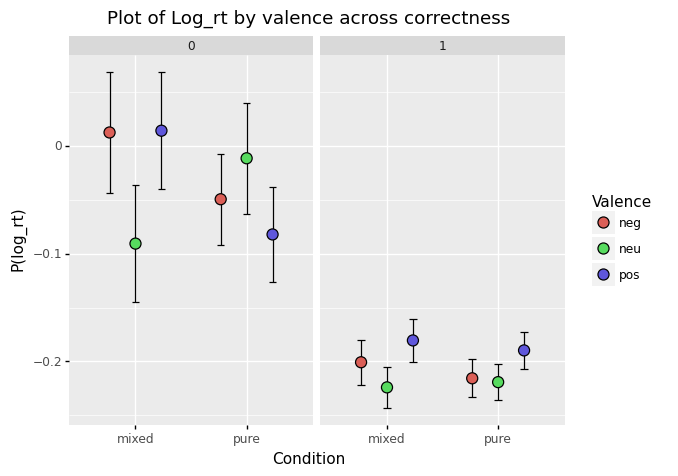

<ggplot: (7012083129)>

In [100]:
p = (pn.ggplot(res, pn.aes('cond', 'mean', fill='valence'))
     + pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', width=0.2), 
                        position=pn.position_dodge(.7))
     + pn.geom_point(position=pn.position_dodge(.7), size=4)
     + pn.facet_wrap('~ correct')
     + pn.labs(title="Plot of Log_rt by valence across correctness", x="Condition", y = "P(log_rt)", fill='Valence')
    )
p

## Statistical test and interpretation

*Perform a statistical test to support your conclusions with regard to your question outlined above. This can be with either statsmodels or with bambi.*

In [94]:
# Code for statistical test (can be either with statsmodels or bambi)

# use the agg method to get the means
perf = df_w.groupby(['subj', 'cond', 'valence', 'correct'])['log_rt'].mean()
perf = perf.reset_index()
perf

,subj,cond,valence,correct,log_rt
0,s001,mixed,neg,0,0.167138
1,s001,mixed,neg,1,-0.217212
2,s001,mixed,neu,0,-0.109757
3,s001,mixed,neu,1,-0.215241
4,s001,mixed,pos,0,0.166381
...,...,...,...,...,...
271,s023,pure,neg,1,-0.284881
272,s023,pure,neu,0,-0.249797
273,s023,pure,neu,1,-0.347838
274,s023,pure,pos,0,-0.357336


In [95]:
# build a linear regression of the full model
m0 = smf.ols("log_rt ~ cond * valence * correct", perf).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_rt   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     4.053
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           1.70e-05
Time:                        22:59:04   Log-Likelihood:                -52.458
No. Observations:                 276   AIC:                             128.9
Df Residuals:                     264   BIC:                             172.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.0358      0.062      0.574      0.566      -0.087       0.159
cond[T.pure]                           -0.0377      0.088     -0.427      0.670      -0.211       0.136
valence[T.neu]                         -0.0979      0.088     -1.110      0.268      -0.272       0.076
valence[T.pos]                          0.0480      0.088      0.544      0.587      -0.126       0.222
cond[T.pure]:valence[T.neu]             0.1971      0.125      1.580      0.115      -0.049       0.443
cond[T.pure]:valence[T.pos]            -0.0671      0.125     -0.538      0.591      -0.313       0.179
correct                                -0.2348      0.088     -2.661      0.008      -0.409      -0.061
cond[T.pure]:correct                    0.0233      0.125      0.186      0.852      -0.222       0.269
valence[T.neu]:correct                  0.0741      0.125      0.594      0.553      -0.172       0.320
valence[T.pos]:correct                 -0.0286      0.125     -0.229      0.819      -0.274       0.217
cond[T.pure]:valence[T.neu]:correct    -0.1750      0.176     -0.992      0.322      -0.522       0.172
cond[T.pure]:valence[T.pos]:correct     0.0680      0.176      0.385      0.700      -0.279       0.415
==============================================================================
Omnibus:                      120.457   Durbin-Watson:                   0.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              535.822
Skew:                           1.794   Prob(JB):                    4.44e-117
Kurtosis:                       8.807   Cond. No.                         25.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
# Run a type-II repeated measures ANOVA based on the linear model results
sm.stats.anova_lm(m0, typ=2)

,sum_sq,df,F,PR(>F)
cond,0.000018,1.0,0.000202,9.886632e-01
valence,0.026583,2.0,0.148474,8.620946e-01
cond:valence,0.256683,2.0,1.433668,2.402830e-01
correct,3.519608,1.0,39.316559,1.463755e-09
cond:correct,0.002658,1.0,0.029688,8.633310e-01
valence:correct,0.004318,2.0,0.024119,9.761714e-01
cond:valence:correct,0.180761,2.0,1.009613,3.657622e-01
Residual,23.633208,264.0,NaN,NaN


*Put text here describing the results of your statistical test

# Discussion

***Graduate students only!!!***

*In one to two paragraphs do the following: a) Place the study in the larger literature, summarizing some of the similar work in the field and how this study compares, b) write some analysis of the findings from the study (even if they are null results) and then describe a follow-up study with a new variant of the experiment that you think might help answer further questions on the topic.